In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
# Supprimer les warnings pour un affichage plus propre
warnings.filterwarnings('ignore')

# Configuration de style pour les graphiques
plt.style.use('default')
sns.set_palette("husl")


In [2]:
def load_bitcoin_data(file_path):
    """
    Charge les données Bitcoin depuis le fichier CSV
    """
    try:
        # Charger les données
        df = pd.read_csv(file_path)
        
        # Convertir la colonne de temps en datetime
        df['Open time'] = pd.to_datetime(df['Open time'])
        
        # Nettoyer les noms de colonnes (enlever les espaces)
        df.columns = df.columns.str.strip()
        
        # Définir l'index comme datetime
        df.set_index('Open time', inplace=True)
        
        print(f"Données chargées avec succès!")
        print(f"Période: {df.index.min()} à {df.index.max()}")
        print(f"Nombre d'enregistrements: {len(df):,}")
        
        return df
        
    except Exception as e:
        print(f"Erreur lors du chargement des données: {e}")
        return None

In [3]:
def basic_statistics(df):
    """
    Affiche les statistiques de base des données Bitcoin
    """
    print("\n" + "="*50)
    print("STATISTIQUES DESCRIPTIVES")
    print("="*50)
    
    # Statistiques pour les prix principaux
    price_cols = ['Open', 'High', 'Low', 'Close']
    print(df[price_cols].describe())
    
    print(f"\n📈 Prix le plus haut: ${df['High'].max():,.2f}")
    print(f"📉 Prix le plus bas: ${df['Low'].min():,.2f}")
    print(f"💰 Prix de clôture actuel: ${df['Close'].iloc[-1]:,.2f}")
    
    # Calcul de la volatilité quotidienne moyenne
    df['Daily_Range'] = ((df['High'] - df['Low']) / df['Open']) * 100
    print(f"🎯 Volatilité moyenne quotidienne: {df['Daily_Range'].mean():.2f}%")

In [4]:

print("🚀 ANALYSE DES DONNÉES BITCOIN")
print("="*50)

# Charger les données
file_path_15m = "btc_15m_data_2018_to_2025.csv"
file_path_1h = "btc_1h_data_2018_to_2025.csv"
file_path_4h = "btc_4h_data_2018_to_2025.csv"
file_path_1d = "btc_1d_data_2018_to_2025.csv"

df_15m = load_bitcoin_data(file_path_15m)
df_1h = load_bitcoin_data(file_path_1h)
df_4h = load_bitcoin_data(file_path_4h)
df_1d = load_bitcoin_data(file_path_1d)

# Afficher les statistiques de base pour les données 1 jour
print("\n🔍 STATISTIQUES DES DONNÉES QUOTIDIENNES")
basic_statistics(df_1d)

🚀 ANALYSE DES DONNÉES BITCOIN
Données chargées avec succès!
Période: 2018-01-01 00:00:00 à 2025-12-10 23:15:00
Nombre d'enregistrements: 277,963
Données chargées avec succès!
Période: 2018-01-01 00:00:00 à 2025-12-23 21:00:00
Nombre d'enregistrements: 69,815
Données chargées avec succès!
Période: 2018-01-01 00:00:00 à 2025-12-23 12:00:00
Nombre d'enregistrements: 17,469
Données chargées avec succès!
Période: 2018-01-01 00:00:00+00:00 à 2025-12-24 00:00:00+00:00
Nombre d'enregistrements: 2,915

🔍 STATISTIQUES DES DONNÉES QUOTIDIENNES

STATISTIQUES DESCRIPTIVES
                Open           High            Low          Close
count    2915.000000    2915.000000    2915.000000    2915.000000
mean    37110.275804   37832.322576   36337.370182   37142.135122
std     32150.297721   32542.441914   31743.382562   32173.536017
min      3211.710000    3276.500000    3156.260000    3211.720000
25%      9433.115000    9667.000000    9206.220000    9437.825000
50%     27242.590000   27756.840000   

## Debut de l'implémentation LSTM - Dataset 15min

On va tenter de prédire la pente du marché, une direction future :
y = -1 → baisse
y =  0 → neutre
y = +1 → hausse

Quel horizon de prédiction ? 
On va tenter de débuter par H = 16, soit prédire la direction pour les 4 heures qui suivent

On implémentera cette formule : r(t,h) = prix(t+h)-prix(t) / prix(t)
Cette formule nous donnera donc une premier pourcentage de baisse/hausse. Ajouté à un seuil défini pour plus de robustesse, on pourra avoir la premiere idée de notre pente, et donc ajouter notre label pour les données d'entrainement
si r > +ε → +1
si r < -ε → -1
sinon → 0

In [5]:
def create_target(df, price_col='Close', horizon=16, threshold=0.002):
    """
    Génération vectorisée de la cible (Target).
    1 = Hausse, -1 = Baisse, 0 = Neutre
    
    Args:
        df: DataFrame contenant les prix
        horizon: Nombre de périodes vers le futur (ex: 16 pour 4h en bougies 15m)
        threshold: Le pourcentage minimum pour valider un mouvement (ex: 0.002 pour 0.2%)
    """
    # Calcul du pourcentage de variation futur
    future_prices = df[price_col].shift(-horizon)
    current_prices = df[price_col]
    
    future_pct = (future_prices - current_prices) / current_prices
    
    conditions = [
        (future_pct > threshold),  # Hausse significative
        (future_pct < -threshold)  # Baisse significative
    ]
    
    choices = [1, -1]
    
    # np.select assigne 1 ou -1 selon les conditions, sinon 0 par défaut
    targets = np.select(conditions, choices, default=0)
    return targets, future_pct

In [6]:
print(df_15m.head())

                         Open      High       Low     Close      Volume  \
Open time                                                                 
2018-01-01 00:00:00  13715.65  13715.65  13400.01  13556.15  123.616013   
2018-01-01 00:15:00  13533.75  13550.87  13402.00  13521.12   98.136430   
2018-01-01 00:30:00  13500.00  13545.37  13450.00  13470.41   79.904037   
2018-01-01 00:45:00  13494.65  13690.87  13450.00  13529.01  141.699719   
2018-01-01 01:00:00  13528.99  13571.74  13402.28  13445.63   72.537533   

                                      Close time  Quote asset volume  \
Open time                                                              
2018-01-01 00:00:00  2018-01-01 00:14:59.999000         1.675545e+06   
2018-01-01 00:15:00  2018-01-01 00:29:59.999000         1.321757e+06   
2018-01-01 00:30:00  2018-01-01 00:44:59.999000         1.078825e+06   
2018-01-01 00:45:00  2018-01-01 00:59:59.999000         1.917783e+06   
2018-01-01 01:00:00  2018-01-01 01:14:59.9

In [7]:
# On travaille sur une copie pour ne pas toucher aux données brutes
df_features = df_15m.copy()

# --- 1. INDICATEURS TECHNIQUES (FEATURE ENGINEERING) ---
df_features['Range_Pct'] = (df_features['High'] - df_features['Low']) / df_features['Open']

df_features['Log_Ret'] = np.log(df_features['Close'] / df_features['Close'].shift(1))

# Moyenne Mobile Simple (SMA) pour la tendance (50 périodes)
df_features['SMA_50'] = df_features['Close'].rolling(window=50).mean()

# Distance au SMA (Normalisée) : Indique si le prix est sur-étendu
df_features['Dist_SMA_50'] = (df_features['Close'] - df_features['SMA_50']) / df_features['SMA_50']

# RSI (Relative Strength Index) - Calcul manuel vectorisé
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df_features['RSI'] = calculate_rsi(df_features['Close'])

# Volume Relatif (Volume actuel / Moyenne des 32 derniers volumes)
df_features['Vol_Ratio'] = df_features['Volume'] / df_features['Volume'].rolling(window=32).mean()


# --- 2. CRÉATION DE LA CIBLE (LABELING) ---

HORIZON_PREDICTION = 16  # 4 heures
SEUIL_VOLATILITE = 0.003

targets, future_ret = create_target(df_features, horizon=HORIZON_PREDICTION, threshold=SEUIL_VOLATILITE)

df_features['Target'] = targets
df_features['Future_Ret'] = future_ret # On enlevera ça après le train

# --- 3. NETTOYAGE ---

df_features.dropna(inplace=True)

# Sélection des colonnes finales pour l'entraînement
features_cols = ['Range_Pct', 'Log_Ret', 'Dist_SMA_50', 'RSI', 'Vol_Ratio']
target_col = ['Target']

print(f"Dataset prêt. Taille : {len(df_features)} lignes")
print(df_features[features_cols + target_col].head())

Dataset prêt. Taille : 277898 lignes
                     Range_Pct   Log_Ret  Dist_SMA_50        RSI  Vol_Ratio  \
Open time                                                                     
2018-01-01 12:15:00   0.014429 -0.007673    -0.025498  33.584776   0.829066   
2018-01-01 12:30:00   0.007551  0.004089    -0.020988  31.291035   0.823557   
2018-01-01 12:45:00   0.008127 -0.002092    -0.022529  31.670116   0.692334   
2018-01-01 13:00:00   0.029255 -0.010025    -0.031662  24.832958   2.470803   
2018-01-01 13:15:00   0.009529 -0.004910    -0.035614  22.358451   1.137726   

                     Target  
Open time                    
2018-01-01 12:15:00      -1  
2018-01-01 12:30:00      -1  
2018-01-01 12:45:00      -1  
2018-01-01 13:00:00       1  
2018-01-01 13:15:00       1  


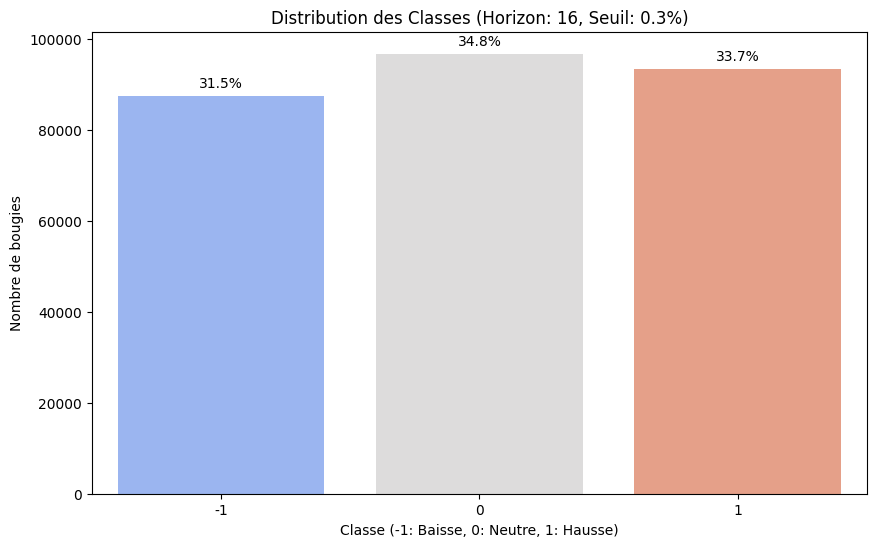

In [8]:
plt.figure(figsize=(10, 6))

# Calcul des pourcentages
distribution = df_features['Target'].value_counts(normalize=True) * 100

ax = sns.countplot(x='Target', data=df_features, palette='coolwarm')
plt.title(f'Distribution des Classes (Horizon: 16, Seuil: {SEUIL_VOLATILITE*100}%)')
plt.xlabel('Classe (-1: Baisse, 0: Neutre, 1: Hausse)')
plt.ylabel('Nombre de bougies')
for p in ax.patches:
    ax.annotate(f'{p.get_height()/len(df_features)*100:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.show()

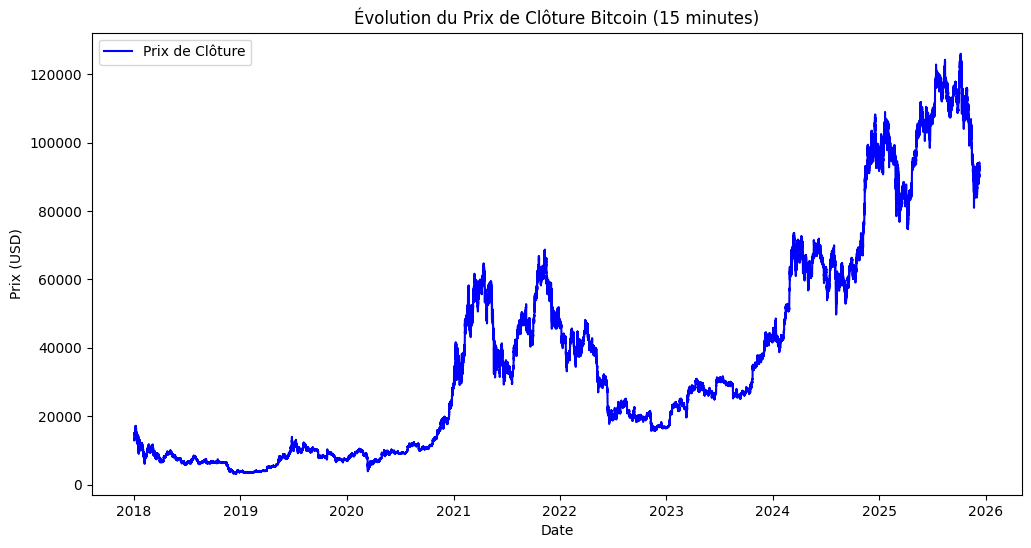

In [9]:
#Visualiser les prix

plt.figure(figsize=(12, 6))
plt.plot(df_features.index, df_features['Close'], label='Prix de Clôture', color='blue')
plt.title('Évolution du Prix de Clôture Bitcoin (15 minutes)')
plt.xlabel('Date')
plt.ylabel('Prix (USD)')
plt.legend()
plt.show()

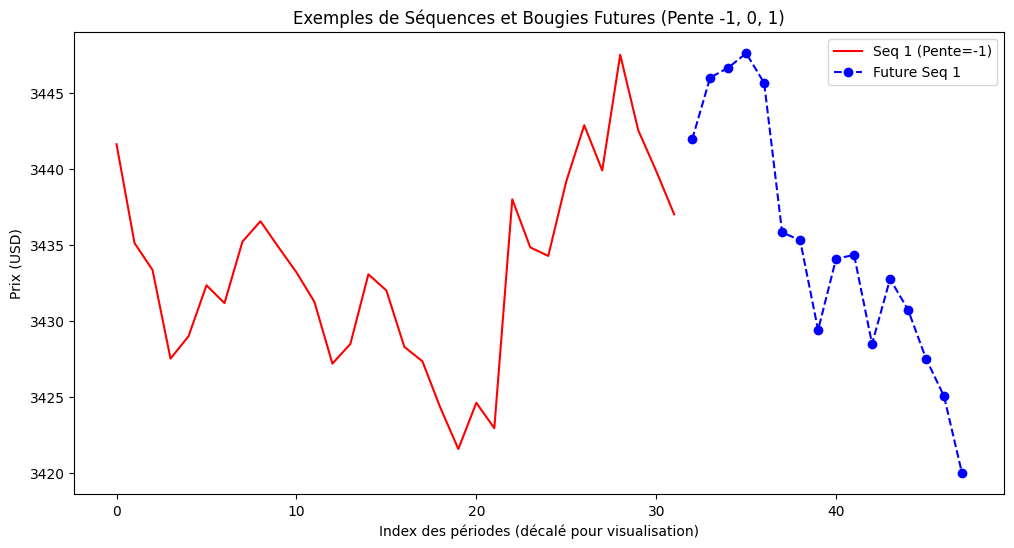

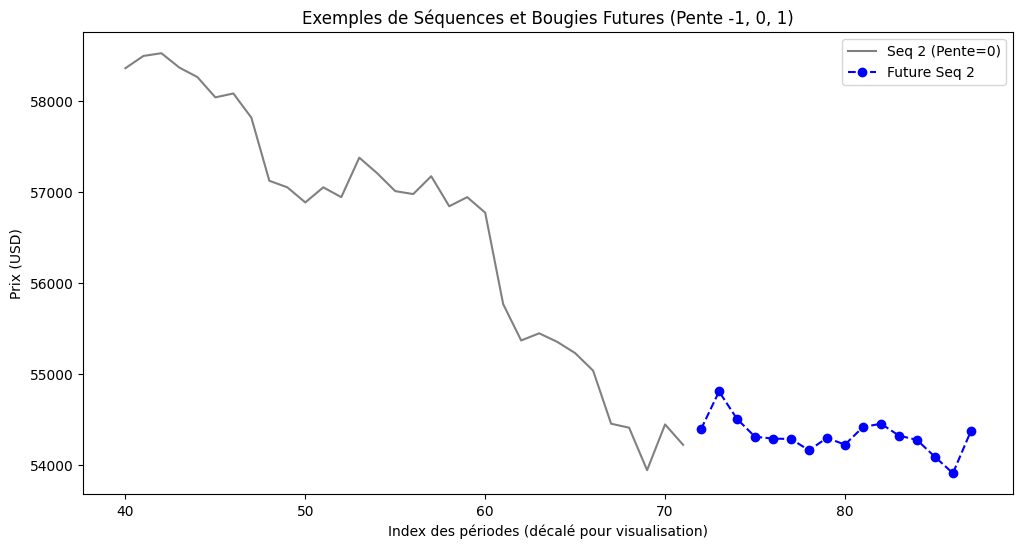

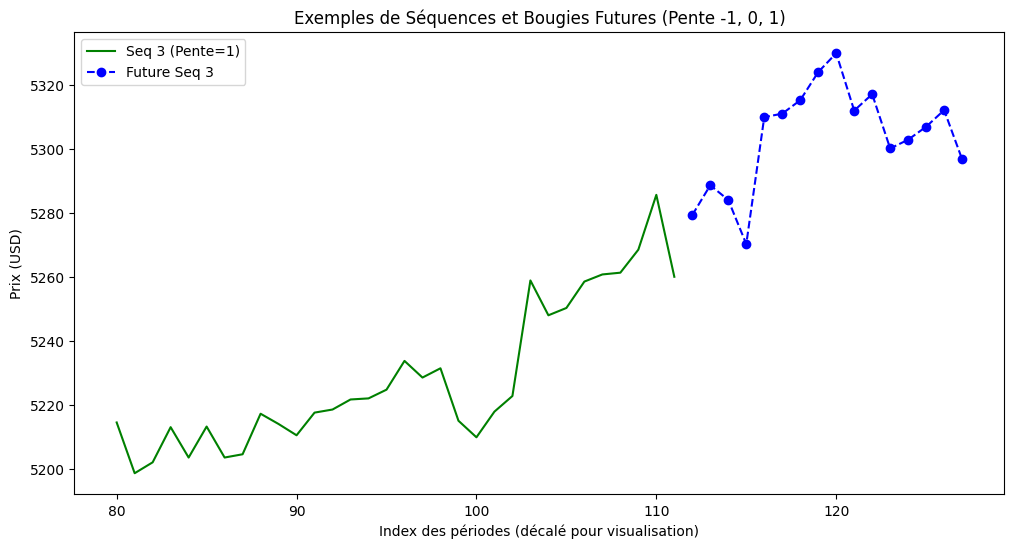

In [10]:
# Fonction pour récupérer un indice aléatoire pour une pente spécifique
def random_index_for_pente(df, pente_val):
    indices = np.where(df['Target'].values == pente_val)[0]
    # Filtrer les indices qui permettent de prendre 32 bougies + 16 futures
    valid_indices = [idx for idx in indices if idx >= 31 and idx + 16 < len(df)]
    if len(valid_indices) == 0:
        return None
    # Choisir un indice aléatoire parmi les valides
    return np.random.choice(valid_indices)

# Récupérer les indices pour chaque pente
idx_neg = random_index_for_pente(df_features, -1)
idx_zero = random_index_for_pente(df_features, 0)
idx_pos = random_index_for_pente(df_features, 1)

example_indices = [idx_neg, idx_zero, idx_pos]



for i, label_idx in enumerate(example_indices):
    # Séquence LSTM : 32 bougies avant le label
    plt.figure(figsize=(12, 6))
    seq = df_features['Close'].values[label_idx-31:label_idx+1]
    pente = df_features['Target'].values[label_idx]
    color_seq = 'green' if pente == 1 else 'red' if pente == -1 else 'gray'

    # Prochaines 16 bougies (horizon)
    future = df_features['Close'].values[label_idx+1:label_idx+17]

    # Décalage horizontal pour visualisation
    offset = i * 40
    plt.plot(range(offset, offset+32), seq, color=color_seq, label=f'Seq {i+1} (Pente={pente})')
    plt.plot(range(offset+32, offset+48), future, color='blue', linestyle='--', marker='o', label=f'Future Seq {i+1}')

    plt.title('Exemples de Séquences et Bougies Futures (Pente -1, 0, 1)')
    plt.xlabel('Index des périodes (décalé pour visualisation)')
    plt.ylabel('Prix (USD)')
    plt.legend()
    plt.show()


## Implémentation du LSTM avec Pytorch

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

def prepare_data_lstm(df, feature_cols, target_col, time_steps=60, train_size=0.8):
    """
    Prépare les séquences pour le LSTM avec une séparation stricte Train/Test.
    """
    print("--- Préparation des données LSTM ---")
    
    # 1. Séparation Temporelle (SANS SHUFFLE)
    split_idx = int(len(df) * train_size)
    df_train = df.iloc[:split_idx].copy()
    df_test = df.iloc[split_idx:].copy()
    
    print(f"Train set: {len(df_train)} bougies | Test set: {len(df_test)} bougies")
    
    # 2. Normalisation (Fit sur Train UNIQUEMENT)
    scaler = StandardScaler()
    
    # On fit uniquement sur les features du train
    X_train_scaled = scaler.fit_transform(df_train[feature_cols])
    # On applique la transformation sur le test (sans re-fitter)
    X_test_scaled = scaler.transform(df_test[feature_cols])
    
    # 3. Mapping des cibles (-1, 0, 1) -> (0, 1, 2)
    # 0: Baisse, 1: Neutre, 2: Hausse
    y_map = {-1: 0, 0: 1, 1: 2}
    y_train_mapped = df_train[target_col].map(y_map).values
    y_test_mapped = df_test[target_col].map(y_map).values
    
    # 4. Création des séquences (Fenêtres glissantes)
    def create_sequences(X, y, time_steps):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            Xs.append(X[i:(i + time_steps)])
            ys.append(y[i + time_steps]) # On prédit le label qui suit la séquence
        return np.array(Xs), np.array(ys)
    
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_mapped, time_steps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_mapped, time_steps)
    
    print(f"Forme des données Train : X={X_train_seq.shape}, y={y_train_seq.shape}")
    print(f"Forme des données Test  : X={X_test_seq.shape}, y={y_test_seq.shape}")
    
    return X_train_seq, y_train_seq, X_test_seq, y_test_seq, scaler

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_lstm_model(input_shape, num_classes=3):
    """
    Architecture LSTM optimisée pour les séries financières
    """
    model = Sequential()
    
    # Première couche LSTM
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3)) # Lutte contre le sur-apprentissage
    
    # Deuxième couche LSTM
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.3))
    
    # Couche Dense intermédiaire
    model.add(Dense(16, activation='relu'))
    
    # Couche de sortie (Softmax pour classification multi-classes)
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compilation
    # sparse_categorical_crossentropy permet d'utiliser les labels (0,1,2) directement sans One-Hot encoding
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

print("Fonction de construction du modèle chargée.")

Fonction de construction du modèle chargée.


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- PARAMÈTRES ---
TIME_STEPS = 60   # Le modèle regarde les 60 dernières bougies (15h de passé) pour prédire
BATCH_SIZE = 64
EPOCHS = 50

# 1. Préparation
X_train, y_train, X_test, y_test, scaler = prepare_data_lstm(
    df_features, 
    features_cols, 
    'Target', 
    time_steps=TIME_STEPS
)

# 2. Gestion du déséquilibre des classes
# C'est vital sinon le modèle prédira toujours "Neutre" (Classe 1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Poids des classes : {class_weights_dict}")

# 3. Construction
model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
model.summary()

# 4. Callbacks (Arrêt automatique et réduction du learning rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

# 5. Entraînement
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict, # Application des poids
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

--- Préparation des données LSTM ---
Train set: 222318 bougies | Test set: 55580 bougies
Forme des données Train : X=(222258, 60, 5), y=(222258,)
Forme des données Test  : X=(55520, 60, 5), y=(55520,)
Poids des classes : {0: 1.0413234756697496, 1: 0.9831466638356601, 2: 0.9779555414752626}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,915 (120.76 KB)

 Trainable params: 30,915 (120.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3473/3473 ━━━━━━━━━━━━━━━━━━━━ 100s 28ms/step - accuracy: 0.4411 - loss: 1.0477 - val_accuracy: 0.4243 - val_loss: 1.0638 - learning_rate: 0.0010
Epoch 2/50
3473/3473 ━━━━━━━━━━━━━━━━━━━━ 104s 30ms/step - accuracy: 0.4517 - loss: 1.0407 - val_accuracy: 0.4238 - val_loss: 1.0640 - learning_rate: 0.0010
Epoch 3/50
3473/3473 ━━━━━━━━━━━━━━━━━━━━ 116s 33ms/step - accuracy: 0.4578 - loss: 1.0363 - val_accuracy: 0.4238 - val_loss: 1.0765 - learning_rate: 0.0010
Epoch 4/50
3473/3473 ━━━━━━━━━━━━━━━━━━━━ 108s 31ms/step - accuracy: 0.4693 - loss: 1.0279 - val_accuracy: 0.4237 - val_loss: 1.0675 - learning_rate: 5.0000e-04
Epoch 5/50
3473/3473 ━━━━━━━━━━━━━━━━━━━━ 105s 30ms/step - accuracy: 0.4799 - loss: 1.0204 - val_accuracy: 0.4165 - val_loss: 1.0762 - learning_rate: 5.0000e-04
Epoch 6/50
3473/3473 ━━━━━━━━━━━━━━━━━━━━ 103s 30ms/step - accuracy: 0.4933 - loss: 1.0081 - val_accuracy: 0.4174 - val_loss: 1.0888 - learning_rate: 2.5000e-04


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step

--- RAPPORT DE CLASSIFICATION ---
              precision    recall  f1-score   support

      Baisse       0.36      0.25      0.30     16338
      Neutre       0.45      0.78      0.57     21413
      Hausse       0.42      0.15      0.22     17769

    accuracy                           0.42     55520
   macro avg       0.41      0.40      0.36     55520
weighted avg       0.41      0.42      0.38     55520


--- MATRICE DE CONFUSION ---


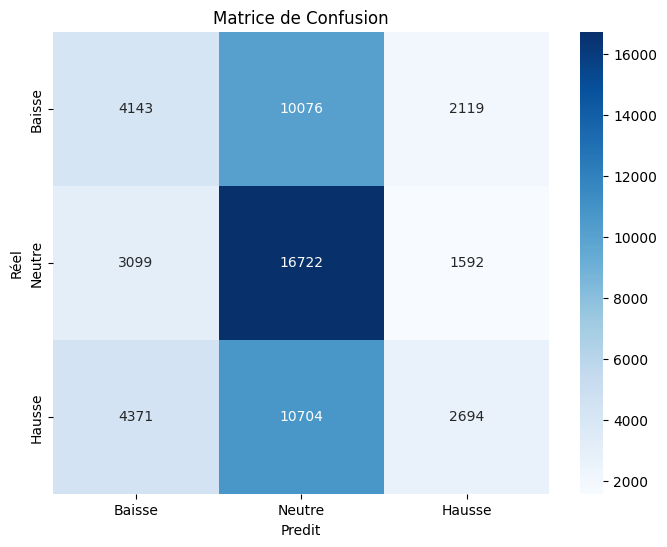

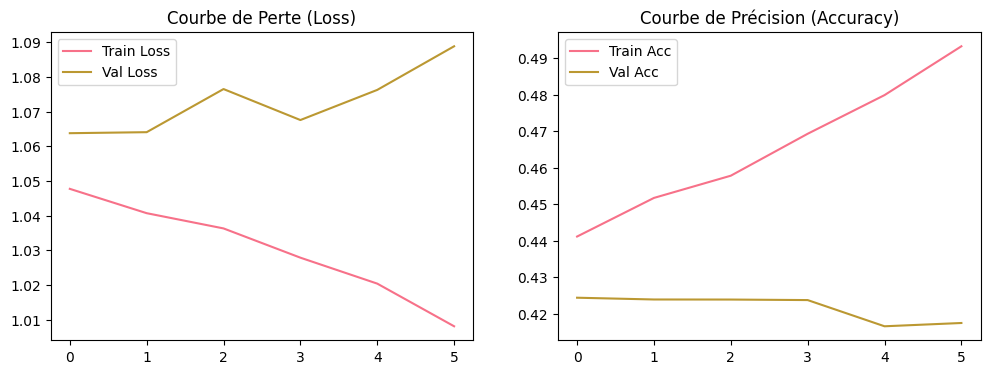

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

# Prédiction
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Mapping inverse pour l'affichage
# 0 -> Baisse, 1 -> Neutre, 2 -> Hausse
target_names = ['Baisse', 'Neutre', 'Hausse']

print("\n--- RAPPORT DE CLASSIFICATION ---")
print(classification_report(y_test, y_pred, target_names=target_names))

print("\n--- MATRICE DE CONFUSION ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion')
plt.show()

# Affichage des courbes d'apprentissage
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Courbe de Perte (Loss)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Courbe de Précision (Accuracy)')
plt.legend()
plt.show()

In [15]:
#Visualisation des pertes d'entraînement et de validation




